In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from functools import partial
from Nexis_model_seedop import run_Nexis
from scipy.stats import pearsonr
import seaborn as sns


## Preparing Inputs

In [2]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis 
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [3]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Converting region order of DK to that of connectivity matrix
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

In [4]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1)) # Cell type matrix (nROI x nTypes)/ gene_data_reordered
t_vec_ = np.linspace(0, 15, 16)  # Time vector in terms of stages outputted by EBM (16 stages) # CHANGE LATER: 100 time points once time vs. stage relationship has been specified
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
logistic_term_ = 0 # Binary flag set to 1 to run with logistic term and 0 to run without

## Load Patient Data

In [5]:
# Upload patient data
patient_data = pandas.read_csv('Cross-sectional stage and regional tau.csv')

RID = 21 #EDIT PATIENT RID MANUALLY HERE
patient = patient_data[patient_data['RID'] == RID] 

# Define number of time points 
num_time_points = patient.shape[0]

# Define list with stage assingments for each time point
stages = patient['ml_stage'].tolist()
stages = [int(x) for x in stages]
# LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

# Define patient tau data
patient_tau = patient.iloc[:,3:]

# Reorder regions to match region order of connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
patient_tau = patient_tau.iloc[:, new_order_ADNI]

# Delete striatal regions 
patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

# Convert to array and transpose so dim = nROI x # of stages
patient_tau = patient_tau.to_numpy()
patient_tau = patient_tau.T

## Parameter Optimization

In [8]:
# SET LAMBDA HERE (for L1 regularization)
Lambda = 0.001

# Define a function that runs Nexis and calculates the MSE 
def Nexis_MSE(params, patient_tau):
        
        param1 = params # param1 = initial vector

        # Initialize run_Nexis class 
        nexis_model_mse = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                            volcorrect_=volcorrect_, region_volumes_=region_volumes_, logistic_term_=1)

        # Parameters for simulate_nexis method
        parameters = [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493, param1]  # [alpha, beta, gamma, s, b, p , k, inital vector] 

        # Call the simulate_nexis method with the parameters
        Y = nexis_model_mse.simulate_nexis(parameters)

        # For optimization, only take stages from Y that correspond to patient's stages 
        Y_edited = Y[:, stages] 

        error = mse_matrix(patient_tau,Y_edited) + Lambda * param1.sum()
        
        return error

In [9]:
#Optimize parameters by minimizing MSE between patient data and Y
custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

# Initial guesses for initial vector
seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # Manually edit guess for seeding region here
seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]
array_length = nROI
init_guess = np.zeros(array_length)
init_guess[seeding_indices[0]] = 1 
init_guess[seeding_indices[1]] = 1

# Bounds for initial vector
bounds = [(0, 3) for _ in range(nROI)]

# Perform the optimization
result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                      options={'ftol': 1e-3, 'gtol': 1e-3,'maxiter': 1000}) 

# Check the results
if result.success:
    optimized_initial_vec = result.x
    optimized_initial_vec = optimized_initial_vec.tolist()

    print(f"Optimization successful. Optimized initial vector: {optimized_initial_vec}")
else:
    print("Optimization failed.", result.message)
    

Optimization successful. Optimized initial vector: [0.026210951212482105, 0.0, 0.29954515316947616, 0.8088248449721944, 0.0, 0.19970760622255215, 0.0, 0.16195545823138421, 0.605060827497884, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09361340637795602, 0.06065215254664915, 0.0, 0.0, 0.04916042285195431, 0.12738818734751853, 0.22463550449095834, 0.03380410008545213, 0.04694721565988193, 0.0, 0.0, 0.0, 0.0, 0.148297556134913, 0.014609837753061811, 0.009745059258121642, 0.0, 0.0, 0.0, 0.0, 0.029101583293884774, 0.16150284825650904, 0.0, 0.0, 0.11512163000801592, 0.0, 0.0, 0.0, 0.0, 0.34467147038661283, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8023620304392913, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02053183855568109, 1.1537152886755209, 0.0, 0.0, 0.0, 0.0, 0.011419100913991766, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0140309570511518, 0.0]


Text(0.5, 1.0, 'Initial vector')

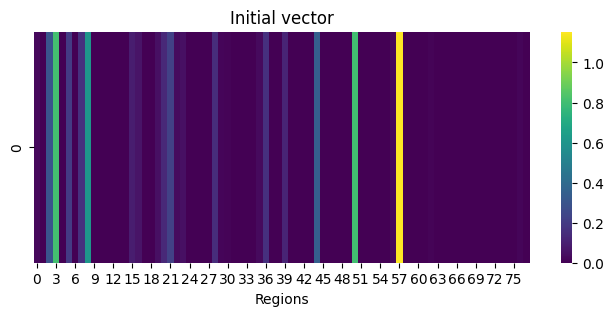

In [10]:
# Create a heatmap of initial vector
plt.figure(figsize=(8, 3)) 
sns.heatmap([optimized_initial_vec], cmap='viridis')
# Add labels and title
plt.xlabel('Regions')
plt.title('Initial vector')

In [88]:
# DELETE LATER (for sake of comparison to inverse_Nexis)

# Thresholding
tau_threshold = 50 # SET PERCENTILE THRESHOLD HERE
x0_thresholded = optimized_initial_vec.copy()  
x0_thresholded = np.array(x0_thresholded)
tau_percentile = np.percentile(x0_thresholded, tau_threshold)
x0_thresholded[x0_thresholded < tau_percentile] = 0
#x0_thresholded = x0_thresholded.tolist()
print((x0_thresholded))

# Calculate sparcity
l2_norm = np.linalg.norm(x0_thresholded, ord=2)
# Calculate the 75th percentile value
percentile_75th = np.percentile(x0_thresholded, 75)
# Get the values in the vector that are below the 75th percentile
lower_75th_values = x0_thresholded[x0_thresholded < percentile_75th]
l2_norm_lower = np.linalg.norm(lower_75th_values, ord=2)
sparcity = l2_norm / l2_norm_lower
print('Sparcity: ' + str(sparcity))

# Save to csv
x0_thresholded_df = pandas.DataFrame(x0_thresholded)
x0_thresholded_df.to_csv('minimize() initial vector.csv')

[3.38201574e-02 0.00000000e+00 2.90753930e-01 8.76127997e-01
 1.73923488e-01 2.11908784e-01 0.00000000e+00 1.47853677e-01
 6.61964839e-01 3.20700622e-02 0.00000000e+00 4.63130075e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.59604933e-02
 9.18209460e-02 0.00000000e+00 7.39091858e-02 3.94485623e-02
 1.13926829e-01 2.80810549e-01 9.47763566e-02 5.38672124e-02
 1.13171341e-02 0.00000000e+00 0.00000000e+00 5.61215716e-03
 3.12909996e-01 9.09658322e-03 1.08267373e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.08785312e-03 3.54041605e-02
 8.51071989e-02 0.00000000e+00 0.00000000e+00 1.39794630e-01
 0.00000000e+00 0.00000000e+00 3.96999065e-02 0.00000000e+00
 6.71103806e-01 1.07473537e-03 0.00000000e+00 0.00000000e+00
 5.94180674e-02 0.00000000e+00 7.50205629e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.71908196e-02
 7.72454605e-02 1.12922236e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.81768003e-01 0.00000000e+00
 0.00000000e+00 0.000000

## Running Nexis

[[0.02621095 0.04915549 0.08123405 ... 2.63243717 3.33753828 4.17739263]
 [0.         0.0379789  0.07684851 ... 2.14337572 2.73371272 3.45143491]
 [0.29954515 0.25269229 0.24286239 ... 2.12156819 2.69144929 3.38823637]
 ...
 [0.         0.11847684 0.22132071 ... 2.7666851  3.39586178 4.14376023]
 [0.01403096 0.08109422 0.19051573 ... 2.60261751 3.21974403 3.95824231]
 [0.         0.07116388 0.14415949 ... 2.53370679 3.15378017 3.89564813]]


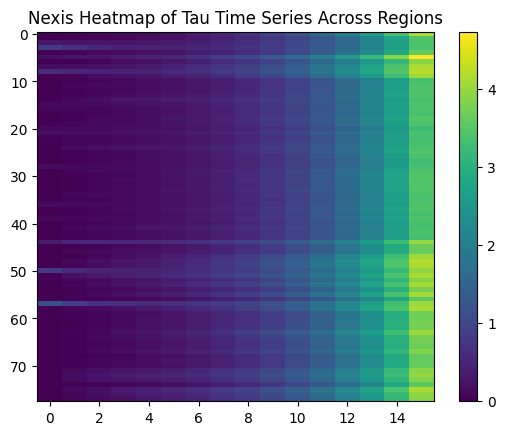

In [12]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, logistic_term_=1)

# Parameters for simulate_nexis method
parameters =  [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

# Print resulting matrix (nROI x # of time points)
print(Y)

# Take stages from Y that correspond to patient's stages 
Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap('baseline',Y)

## Check Results

In [13]:
# Calculate MSE between E(t) and Y
mse = mse_matrix(patient_tau, Y_edited)
print('Mean squared error: ' + str(mse))

 # Calculate R (only relevant with longitudinal data)
Y_edited = Y_edited.flatten() 
patient_tau = patient_tau.flatten() 
R, p_value = pearsonr(Y_edited, patient_tau)
print('Pearsons R: ' + str(R))


Mean squared error: 0.04194404301702203
Pearsons R: 0.5205736541059636


<function matplotlib.pyplot.show(close=None, block=None)>

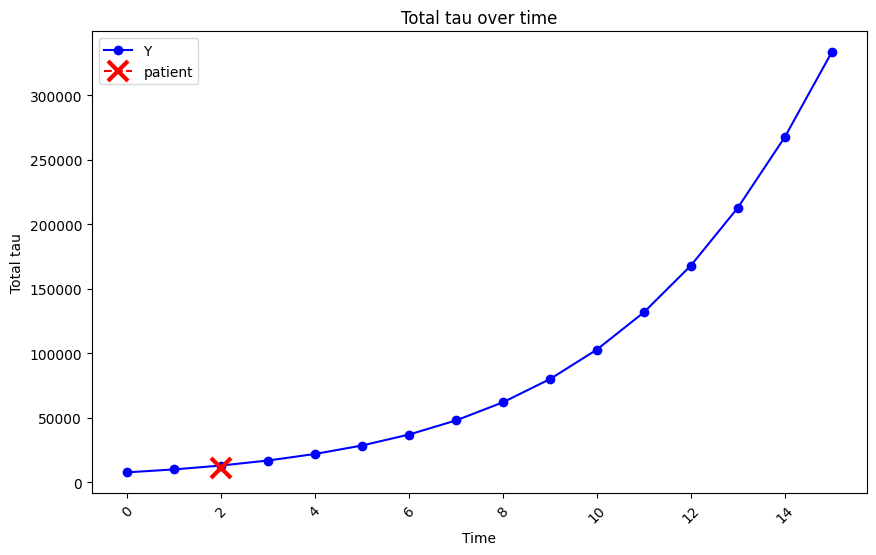

In [14]:
# Plot total tau over time for patient tau and Y_edited

# Volume correction
regional_volumes_array = np.array(regional_volumes_excluded)
regional_volumes_array = regional_volumes_array.reshape((78,1))
tau_mass_Y = regional_volumes_array * Y
total_tau_Y = np.sum(tau_mass_Y, axis=0)
patient_tau = patient_tau.reshape(78,1)
tau_mass_patient = regional_volumes_array * patient_tau
total_tau_patient = np.sum(tau_mass_patient, axis=0)

time_points_Y = np.linspace(0, 15, 16)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

# Plot total_tau_patient on the same graph
plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)

plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show

## Loop through all subjects

In [16]:
# Avoid repeating any RIDS
unique_rids = patient_data['RID'].unique()

#Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala',	'Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus','ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
seeding_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,3:]

    # Reorder regions to match region order of connectivity matrix
    patient_tau = patient_tau.iloc[:, new_order_ADNI]

    # Delete striatal regions 
    patient_tau = patient_tau.drop(regions_to_exclude, axis = 1)

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Perform the optimization
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

    result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-3, 'gtol': 1e-3, 'maxiter': 1000})
    
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )

    # Run Nexis    
    parameters =  [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE
    Y = nexis_model.simulate_nexis(parameters) 
    Y_edited = Y[:, stages]
    
    # Calculate MSE
    mse = mse_matrix(patient_tau, Y_edited)
    
    # Create data frame for the subject
    seeding = pandas.DataFrame([[rid] + optimized_initial_vec + [mse]], columns=column_names)

    # Concatenate the original DataFrame with the new DataFrame
    seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)

seeding_all

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1376/3355237.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)


,RID,MSE,ctx-rh-bankssts,ctx-rh-caudalanteriorcingulate,ctx-rh-caudalmiddlefrontal,ctx-rh-cuneus,ctx-rh-entorhinal,ctx-rh-fusiform,ctx-rh-inferiorparietal,ctx-rh-inferiortemporal,...,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Hippocampus,Left-Amygdala,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Hippocampus,Right-Amygdala,Right-VentralDC
0,21,0.026211,0.0,0.299545,0.808825,0.000000,0.199708,0.000000,0.161955,0.605061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014031,0.000000,0.041944
1,31,0.000000,0.0,0.000000,0.000000,0.000000,0.039385,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.692659,0.000000,0.000000,0.000000,0.000000,0.000000,0.287261
2,56,0.000000,0.0,0.000000,0.022174,0.000000,0.067802,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.427760,0.000000,0.000000,0.000000,0.000000,0.000000,0.183276
3,59,0.030330,0.0,0.010040,0.001689,0.000000,0.139505,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.663482,0.131299,0.000000,0.000000,0.000000,0.000000,0.168819
4,69,0.092701,0.0,0.372498,0.361093,0.231681,0.395303,0.000000,0.349791,0.365472,...,0.083743,0.072030,0.054929,0.082113,0.124366,0.123653,0.000000,0.096572,0.011451,0.001440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,6704,0.000000,0.0,0.000000,0.000000,0.000000,0.068276,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.469882,0.075946,0.000000,0.000000,0.000000,0.000000,0.429962
648,6705,0.000000,0.0,0.000000,0.000000,0.000000,0.013174,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.062663,0.129084,0.043239,0.000000,0.004526,0.007055,0.031345,0.983323
649,6713,0.000000,0.0,0.000000,0.000000,0.000000,0.054577,0.002198,0.007287,0.000000,...,0.000000,0.000000,0.063578,0.120627,0.041358,0.000000,0.008059,0.006862,0.031067,0.984775
650,6721,0.006625,0.0,0.000000,0.000000,0.000000,0.020186,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.080295,0.166263,0.057391,0.000000,0.008459,0.008596,0.039480,0.968485


Regions with highest average tau seed density: ['ctx-rh-medialorbitofrontal', 'ctx-lh-cuneus', 'ctx-rh-cuneus', 'ctx-rh-fusiform', 'ctx-rh-insula', 'ctx-rh-superiorparietal', 'Left-VentralDC', 'Left-Amygdala', 'Right-Amygdala', 'ctx-lh-inferiortemporal', 'Left-Hippocampus', 'ctx-lh-fusiform', 'ctx-rh-inferiortemporal', 'Right-Hippocampus', 'ctx-lh-bankssts', 'ctx-rh-inferiorparietal', 'ctx-rh-bankssts', 'ctx-lh-entorhinal', 'ctx-lh-inferiorparietal', 'Left-Thalamus-Proper', 'ctx-rh-lateralorbitofrontal', 'ctx-lh-lateralorbitofrontal', 'ctx-rh-middletemporal', 'ctx-rh-entorhinal', 'Right-Thalamus-Proper', 'ctx-lh-middletemporal', 'ctx-lh-insula', 'ctx-lh-lateraloccipital', 'ctx-lh-isthmuscingulate', 'ctx-rh-lateraloccipital', 'ctx-lh-precuneus', 'ctx-rh-precuneus', 'ctx-rh-isthmuscingulate', 'ctx-lh-parsorbitalis', 'ctx-rh-parahippocampal', 'ctx-rh-parsorbitalis', 'ctx-lh-medialorbitofrontal', 'ctx-rh-superiortemporal', 'ctx-lh-rostralmiddlefrontal', 'ctx-lh-parahippocampal', 'MSE', 'ct

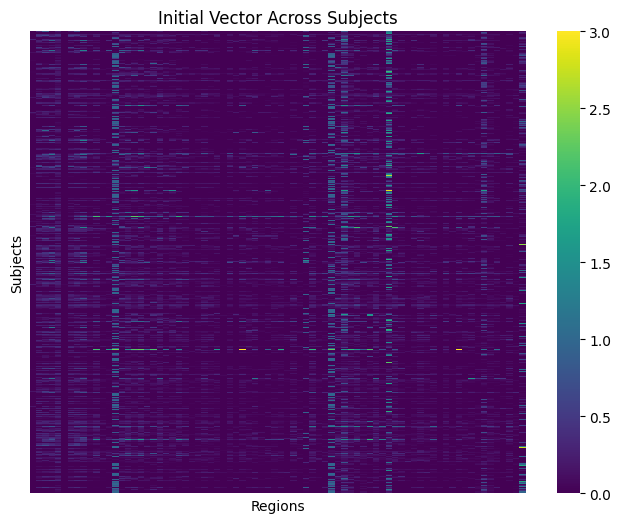

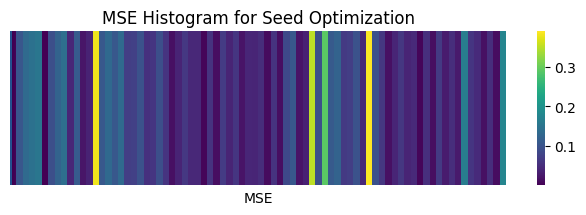

In [77]:
# Plot heat map seeds across subjects
plt.figure(figsize=(8, 6)) 
sns.heatmap(seeding_all.iloc[:,2:], cmap='viridis', xticklabels=False, yticklabels=False, vmin=0, vmax=3)
plt.xlabel('Regions')
plt.ylabel('Subjects')
plt.title('Initial Vector Across Subjects')

# Plot average seed 
column_means = seeding_all.mean(numeric_only=True).to_frame().T
seeding_all_means = pandas.concat([seeding_all, column_means], ignore_index=True)
plt.figure(figsize=(8, 2)) 
sns.heatmap(seeding_all_means.iloc[652:653, 2:], cmap='viridis', xticklabels=False, yticklabels=False)
plt.xlabel('Regions')
plt.title('Average Across Subjects')

# Sort regions by highest averages
sorted_regions = seeding_all_means.iloc[:, 1:].sort_values(by=652, axis=1, ascending=False)
sorted_regions = sorted_regions.columns.tolist()
print('Regions with highest average tau seed density: ' + str(sorted_regions))


Text(0.5, 1.0, 'MSE Histogram for Seed Optimization')

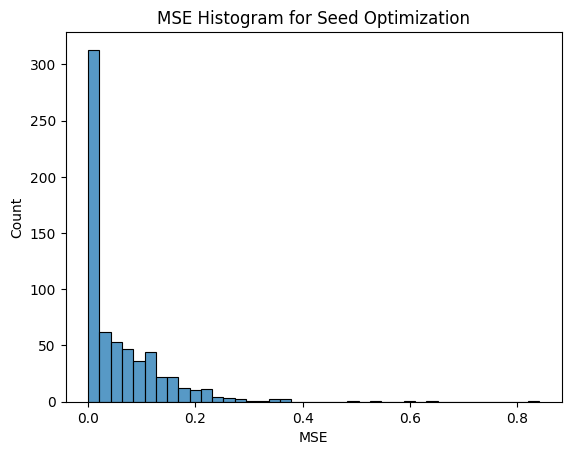

In [80]:
# Create histogram of MSE scores
sns.histplot(seeding_all['MSE'], bins=40, kde=False)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.title('MSE Histogram for Seed Optimization')

In [42]:
# Save to a csv 
seeding_all.to_csv('Seeding patterns.csv')